In [1]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, ElasticNetCV, RidgeCV, LassoCV, LassoLars
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Load the datasets
charging_data = pd.read_csv(r"C:\Users\banan\Desktop\AA\charging_sessions.csv", index_col=0)
weather_data = pd.read_csv(r"C:\Users\banan\Desktop\AA\weather_burbank_airport.csv")

charging_data['connectionTime'] = pd.to_datetime(charging_data['connectionTime'])
charging_data['connectionTime'] = charging_data['connectionTime'].dt.tz_localize(None)
charging_data['disconnectTime'] = pd.to_datetime(charging_data['disconnectTime'])
charging_data['disconnectTime'] = charging_data['disconnectTime'].dt.tz_localize(None)
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])

In [2]:
print(charging_data.head())
print(120 * "=")
print(charging_data.dtypes)
print(120 * "=")
print(weather_data.head())
print(weather_data.dtypes)
print(120 * "=")
print(charging_data.describe())
print(120 * "=")
print(weather_data.describe())

                         id      connectionTime      disconnectTime  \
0  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54 2020-01-02 19:11:15   
1  5e23b149f9af8b5fe4b973d0 2020-01-02 13:36:50 2020-01-02 22:38:21   
2  5e23b149f9af8b5fe4b973d1 2020-01-02 13:56:35 2020-01-03 00:39:22   
3  5e23b149f9af8b5fe4b973d2 2020-01-02 13:59:58 2020-01-02 16:38:39   
4  5e23b149f9af8b5fe4b973d3 2020-01-02 14:00:01 2020-01-02 22:08:40   

            doneChargingTime  kWhDelivered  \
0  2020-01-02 17:31:35+00:00        25.016   
1  2020-01-02 20:18:05+00:00        33.097   
2  2020-01-02 16:35:06+00:00         6.521   
3  2020-01-02 15:18:45+00:00         2.355   
4  2020-01-02 18:17:30+00:00        13.375   

                                sessionID  siteID  spaceID    stationID  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-179-810   
1  1_1_193_825_2020-01-02 13:36:49.599853       1  AG-1F01  1-1-193-825   
2  1_1_193_829_2020-01-02 13:56:35.214993       1  AG-1F03  1-1-193-829

In [3]:
charging_data_1 = charging_data[charging_data["siteID"] == 1]
charging_data_2 = charging_data[charging_data["siteID"] == 2]

def calculate_connected_counts(data, weather):
    
    def count_connections_at_time(query_time):
        # Count how many intervals in charging_data overlap with the query time
        return ((data['connectionTime'] <= query_time) &
                (data['disconnectTime'] >= query_time)).sum()
    
    # Apply the function to the specified timestamp column in weather_data
    weather_copy = weather.copy()
    weather_copy['connected_count'] = weather_copy["timestamp"].apply(count_connections_at_time)
    return weather_copy

# Display the result
result_1 = calculate_connected_counts(charging_data_1, weather_data)
result_2 = calculate_connected_counts(charging_data_2, weather_data)
print(result_1.head())



      city           timestamp  temperature  cloud_cover  \
0  Burbank 2018-01-01 08:53:00          9.0         33.0   
1  Burbank 2018-01-01 09:53:00          9.0         33.0   
2  Burbank 2018-01-01 10:53:00          9.0         21.0   
3  Burbank 2018-01-01 11:53:00          9.0         29.0   
4  Burbank 2018-01-01 12:53:00          8.0         33.0   

  cloud_cover_description  pressure  windspeed  precipitation  \
0                    Fair    991.75        9.0            0.0   
1                    Fair    992.08        0.0            0.0   
2                    Haze    992.08        0.0            0.0   
3           Partly Cloudy    992.08        0.0            0.0   
4                    Fair    992.08        0.0            0.0   

   felt_temperature  connected_count  
0               8.0                0  
1               9.0                0  
2               9.0                0  
3               9.0                0  
4               8.0                0  


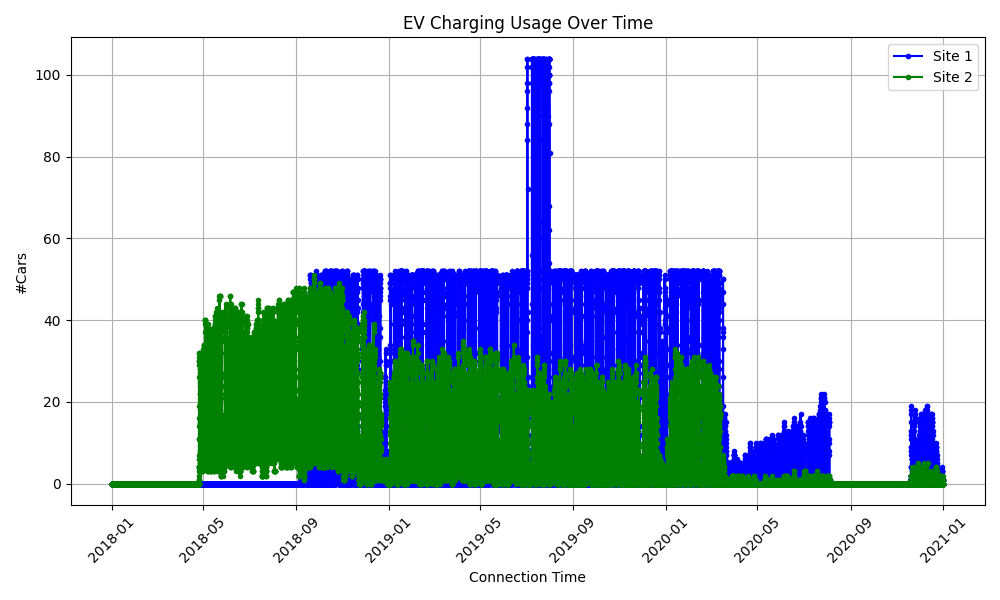

In [4]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result_1['timestamp'], result_1['connected_count'], marker='.', linestyle='-', color='b', label='Site 1')
plt.plot(result_2['timestamp'], result_2['connected_count'], marker='.', linestyle='-', color='g', label='Site 2')
plt.title('EV Charging Usage Over Time')
plt.xlabel('Connection Time')
plt.ylabel('#Cars')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Extracting features
def compute_times(data):
    data['hour'] = data['timestamp'].dt.hour           # Hour of the day
    data['day_of_week'] = data['timestamp'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    #data['is_weekend'] = data['timestamp'].dt.weekday >= 5  # Boolean for weekends
    #data['day_of_year'] = data['timestamp'].dt.dayofyear  # Day of the year
    data['month'] = data['timestamp'].dt.month          # Month
    #data['week_of_year'] = data['timestamp'].dt.isocalendar().week  # Week number
    data['year'] = data['timestamp'].dt.year            # Year
    return data
    
result_1 = compute_times(result_1)
result_2 = compute_times(result_2)

print(result_1.describe())
print(120 * "=")
print(result_2.describe())


                           timestamp   temperature   cloud_cover  \
count                          29244  29219.000000  29224.000000   
mean   2019-06-29 23:51:42.252770048     17.885622     30.107993   
min              2018-01-01 08:53:00      2.000000      4.000000   
25%              2018-10-06 05:38:00     13.000000     26.000000   
50%              2019-06-24 00:23:00     17.000000     33.000000   
75%              2020-03-25 20:08:00     22.000000     34.000000   
max              2021-01-01 07:53:00     46.000000     47.000000   
std                              NaN      6.454604      5.400388   

           pressure     windspeed  precipitation  felt_temperature  \
count  29236.000000  29158.000000   29244.000000      29218.000000   
mean     986.879400      8.566568       0.059360         17.731433   
min      971.000000      0.000000       0.000000          0.000000   
25%      984.500000      6.000000       0.000000         13.000000   
50%      986.480000      7.000000    

In [6]:
#Predictive Analysis for Site 1

In [7]:
#x = result_2[["temperature", "cloud_cover", "pressure", "windspeed", "precipitation", "felt_temperature", "hour", "day_of_week", "month", "is_weekend", "year"]]
x = result_2[["hour", "day_of_week", "month", "year", "precipitation"]]
y = result_2[["connected_count"]]

# Filter DataFrame
start_date = pd.to_datetime("2018-04-26")
end_date = pd.to_datetime("2020-03-01")

i = (result_2['timestamp'] >= start_date) & (result_2['timestamp'] <= end_date)
x = x[i]
y = y[i]

####löschen
# def split_dataframe(df, ratio=0.8):

#     # Calculate the index to split at based on the ratio
#     split_index = int(len(df) * ratio)
    
#     # Split the DataFrame into two parts
#     df1 = df.iloc[:split_index]
#     df2 = df.iloc[split_index:]
    
#     return df1, df2

# x_train, x_test = split_dataframe(x, 0.9)
# y_train, y_test = split_dataframe(y, 0.9)

# x_train, x_val = split_dataframe(x_train, 0.2)
# y_train, y_val = split_dataframe(y_train, 0.2)

# First split: Train/Test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x.describe())
print(y.describe())

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


               hour   day_of_week         month          year  precipitation
count  18123.000000  18123.000000  18123.000000  18123.000000   18123.000000
mean      11.574463      3.006732      6.712465   2018.720797       0.062312
std        6.793566      1.992304      3.490292      0.608915       0.504142
min        0.000000      0.000000      1.000000   2018.000000       0.000000
25%        6.000000      1.000000      4.000000   2018.000000       0.000000
50%       12.000000      3.000000      7.000000   2019.000000       0.000000
75%       17.000000      5.000000     10.000000   2019.000000       0.000000
max       23.000000      6.000000     12.000000   2020.000000      13.970000
       connected_count
count     18123.000000
mean          9.918888
std          11.196928
min           0.000000
25%           2.000000
50%           5.000000
75%          15.000000
max          51.000000
x_train shape: (14498, 5)
x_test shape: (3625, 5)
y_train shape: (14498, 1)
y_test shape: (3625, 1)


In [8]:
# Standardize the features (important for neural networks)
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_val)

# # Build the neural network model
# model = Sequential()
# # Input layer (9 input features) and a hidden layer
# model.add(Dense(64, input_dim=3, activation='relu'))  # 64 units, ReLU activation
# # Another hidden layer
# model.add(Dense(32, activation='relu'))  # 32 units, ReLU activation
# # Output layer (single integer prediction)
# model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Build the neural network model (more complex with more layers and parameters)
model = Sequential()

# Input layer (9 input features) and first hidden layer
model.add(Dense(512, input_dim=5, activation='relu'))  # 512 units, ReLU activation
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second hidden layer
model.add(Dense(256, activation='relu'))  # 256 units, ReLU activation
model.add(Dropout(0.2))  # Dropout layer

# Third hidden layer
model.add(Dense(128, activation='relu'))  # 128 units, ReLU activation
model.add(Dropout(0.2))  # Dropout layer

# Fourth hidden layer
model.add(Dense(64, activation='relu'))  # 64 units, ReLU activation

# Output layer (single integer prediction)
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # Mean Squared Error loss
#model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),  # You can customize learning rate and momentum
              #loss='mse',  # Mean Squared Error loss
              #metrics=['mae'])  # Mean Absolute Error


# Train the model
history = model.fit(x_train, y_train, epochs=80, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f"Validation Loss: {test_loss}, Validation MAE: {test_mae}")

# Make predictions
predictions = model.predict(x_test)
print("Predictions: ", predictions[:5])  # Show first 5 predictions


C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 731.8467 - mae: 16.1629 - val_loss: 158.6516 - val_mae: 7.8920
Epoch 2/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 139.2021 - mae: 9.0605 - val_loss: 135.6504 - val_mae: 7.8803
Epoch 3/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 130.9136 - mae: 8.8801 - val_loss: 129.3095 - val_mae: 8.0038
Epoch 4/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 133.6929 - mae: 9.0881 - val_loss: 129.6270 - val_mae: 7.9746
Epoch 5/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 131.2491 - mae: 8.9612 - val_loss: 139.2800 - val_mae: 7.8053
Epoch 6/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 126.5713 - mae: 8.7603 - val_loss: 118.4913 - val_mae: 8.6858
Epoch 7/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 126.4788 - mae: 8.8905 - val_loss: 118.2696 - val_mae: 7.4452
Epoch 8/80
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 108.3981 - mae: 8.0163 - val_loss: 81.6919 - val_mae: 6.2707
Epoch 9/80
454/454 ━━━━━

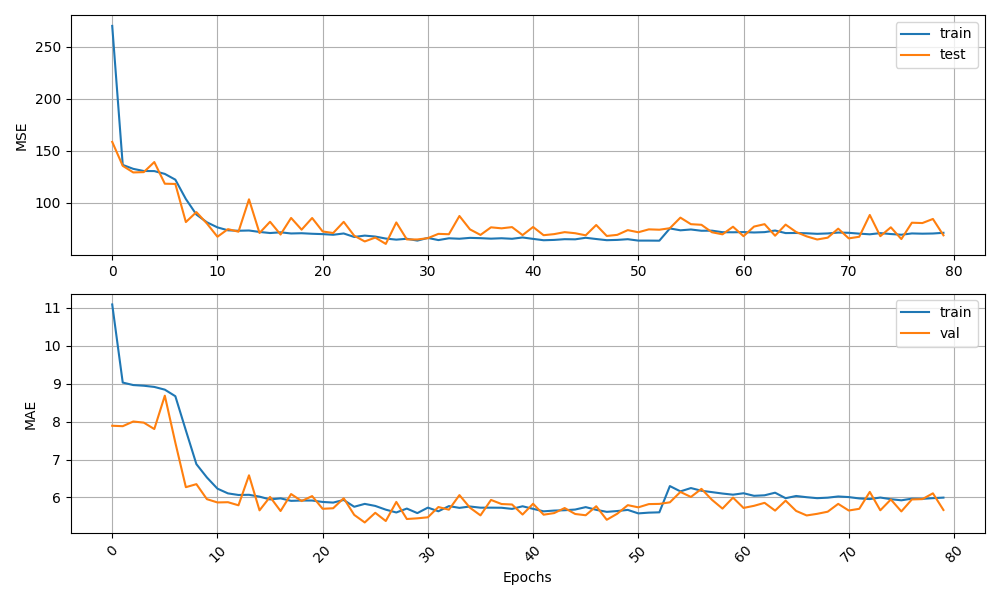

In [11]:
h = history.history
# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(h['loss'], label='train')
plt.plot(h['val_loss'], label='test')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(h['mae'], label='train')
plt.plot(h['val_mae'], label='val')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Create and fit the RandomForest model
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mse, "(RandomForestRegressor)")
print(mae, "(RandomForestRegressor)")

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(LinearRegression)")

# Create and fit the RandomForest model
model = LinearSVR()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(LinearSVR)")

# Create and fit the RandomForest model
model = SVR(kernel="rbf")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(SVR)")

# Create and fit the RandomForest model
model = KNeighborsRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(KNeighborsRegressor)")

# Create and fit the RandomForest model
model = Lasso()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(Lasso)")

model = LassoCV()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(LassoCV)")

model = LassoLars()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(LassoLars)")

model = ElasticNet()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(ElasticNet)")

model = ElasticNetCV()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(ElasticNetCV)")

model = Ridge()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(Ridge)")

model = RidgeCV()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(RidgeCV)")

model = DecisionTreeRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(DecisionTreeRegressor)")

model = MLPRegressor(verbose=False, early_stopping=True, max_iter=10000, n_iter_no_change=20, hidden_layer_sizes=(100, 100, 100))
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mae, "(MLPRegressor)")

# # Create and fit the RandomForest model
# model = MLPRegressor(verbose=True, early_stopping=True, max_iter=10000, n_iter_no_change=30, hidden_layer_sizes=(100, 100))
# #model.fit(x_train, y_train)
# print(x_train.shape)
# print(y_test.shape)
# # Einstellen der Parameter für die Kreuzvalidierung
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
# print(f"Durchschnittlicher Mean Squared Error während Kreuzvalidierung: {np.mean(-scores)}")
# y_pred = model.predict(x_test)
# mae = mean_absolute_error(y_test, y_pred)


C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


16.025211951298242 (RandomForestRegressor)
2.350652790142683 (RandomForestRegressor)
7.156197336049856 (LinearRegression)


C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


12.797552743893219 (LinearSVR)
7.799366320804903 (SVR)
2.5442206896551727 (KNeighborsRegressor)
7.262370016181556 (Lasso)


C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1653: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1653: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


7.155288547615298 (LassoCV)
7.262363891775533 (LassoLars)
7.351992081138931 (ElasticNet)
7.149722803600196 (ElasticNetCV)
7.156172407104048 (Ridge)
7.1561724072751405 (RidgeCV)
2.403072030651341 (DecisionTreeRegressor)


C:\Users\banan\anaconda3\envs\niki\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4.533270882353306 (MLPRegressor)
